In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from keras.datasets import fashion_mnist
from keras.models import Model,Sequential
from keras.layers import Input,Dense,concatenate,Lambda,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.optimizers import Adam
import keras.backend as K
import keras

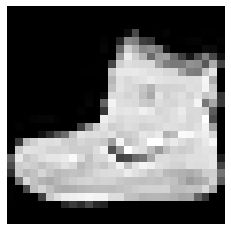

In [41]:
img_size = 28
label_size = 10
n_in = img_size**2
n_out = img_size**2
n_z = 2
m = 3

#digits_data = datasets.load_digits()
#x_train = np.asarray(digits_data.data)
#x_train /= 16
#t_vector = digits_data.target
#t_train = np.eye(len(np.unique(t_vector)))[t_vector]

data = fashion_mnist.load_data()
((x_train,t_train),(x_test,t_test)) = data
x_train = (x_train.reshape(60000,784)/255).astype('float32')
x_test = (x_test.reshape(10000,784)/255).astype('float32')
t_train = keras.utils.to_categorical(t_train,len(np.unique(t_train)))
t_test = keras.utils.to_categorical(t_test,len(np.unique(t_test)))

plt.imshow(x_train[0,:].reshape(28,-1),cmap='gray')
plt.axis('off')
plt.show()

In [10]:
def sample_z(args):
    mu, log_sigma = args
    #eps = K.random_normal(shape=(m, n_z), mean=0., std=1.)
    eps = K.random_normal(shape=(m, n_z), mean=0.)
    return mu + K.exp(log_sigma / 2.) * eps

img_input = Input(batch_shape=(m,img_size*img_size)) 
label_input = Input(batch_shape=(m,label_size))
inputs = concatenate([img_input,label_input],axis=1)
encoder_hidden = Dense(128,activation='relu')(inputs)
mu = Dense(n_z,activation='linear')(encoder_hidden)
sigma = Dense(n_z,activation='linear')(encoder_hidden)
z = Lambda(sample_z)([mu, sigma])
z_cond = concatenate([z, label_input],axis=1)
decoder_hidden = Dense(128, activation='relu')
decoder_hidden_cvae = decoder_hidden(z_cond)
decoder_output = Dense(img_size*img_size, activation='sigmoid')
output = decoder_output(decoder_hidden_cvae)

#CVAE
cvae = Model([img_input,label_input],output)
cvae.summary()

#Decoder
d_z_input = Input(shape=(n_z,))
d_label_input = Input(shape=(label_size,))
d_cond = concatenate([d_z_input,d_label_input],axis=1)
d_hidden = decoder_hidden(d_cond)
d_output = decoder_output(d_hidden)
decoder = Model([d_z_input,d_label_input],d_output)

decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (3, 784)             0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (3, 10)              0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (3, 794)             0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (3, 128)             101760      concatenate_1[0][0]        

In [11]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for eatch data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(sigma) + K.square(mu) - 1. - sigma, axis=1)
    
    return recon + kl

cvae.compile(loss=vae_loss,optimizer=Adam())

In [12]:
history = cvae.fit([x_train,t_train],x_train,batch_size=m,epochs=1,verbose=1)

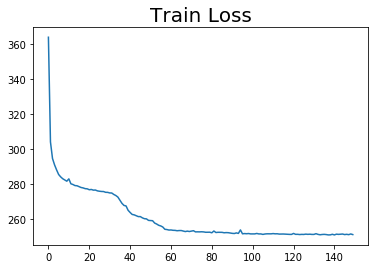

In [13]:
plt.plot(history.history['loss'])
plt.title('Train Loss',fontsize=20)
plt.show()

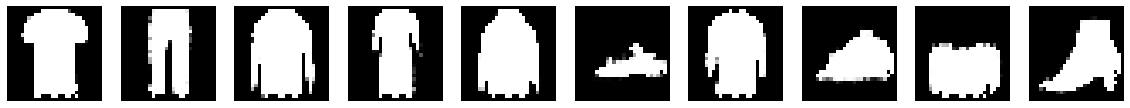

In [14]:
from keras.utils import np_utils
digit_size = img_size

z_sample = np.random.rand(1, n_z) # random 

plt.figure(figsize=(20, 2))
for i in range(10):
    c = np_utils.to_categorical(i,label_size)
    #x_decoded = decoder.predict([z_sample, c])
    x_decoded = decoder.predict([z_sample,np.array([c])])
    digit = x_decoded[0].reshape(digit_size, digit_size)

    plt.subplot(1, label_size, i+1)
    plt.axis('off')
    plt.imshow(digit, cmap='Greys_r',)
plt.show()

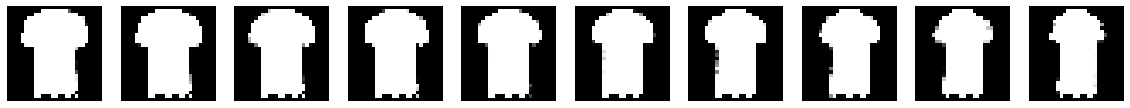

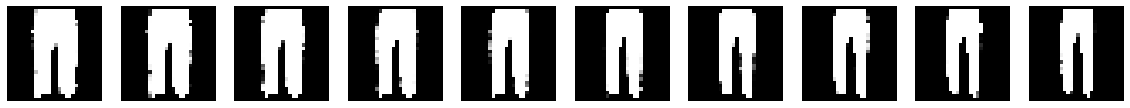

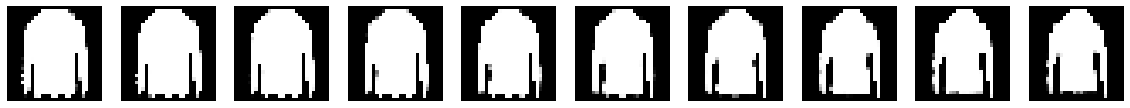

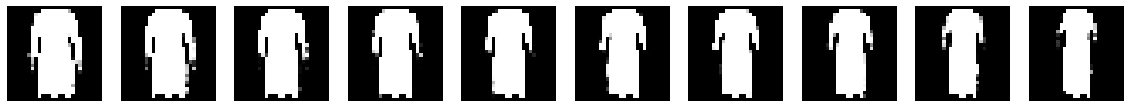

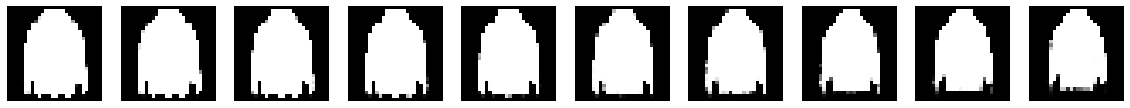

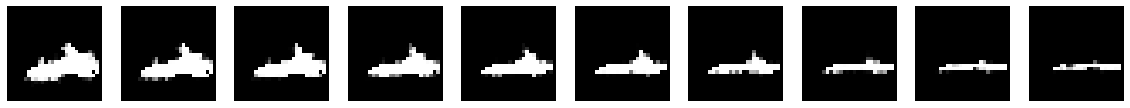

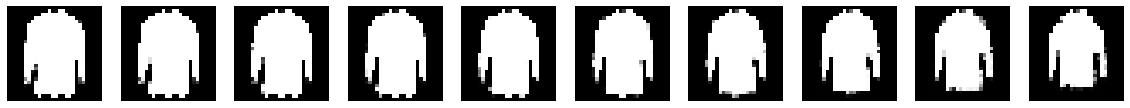

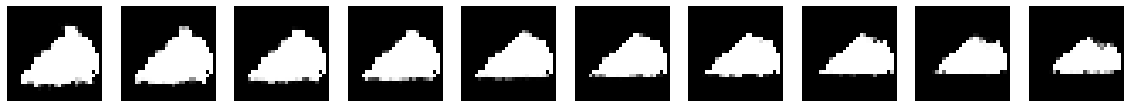

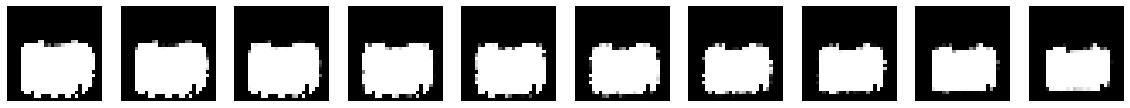

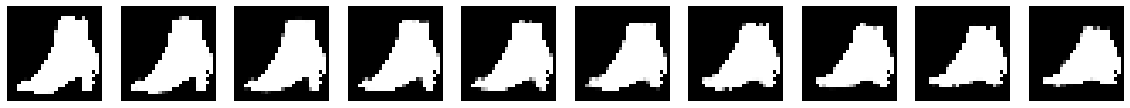

In [35]:
for j in range(10):
    c = np_utils.to_categorical(j,label_size)

    plt.figure(figsize=(20, 2))
    for i in range(10):
        #z_sample = np.array([[0.1 * i, 0.1*i]])
        z_sample = np.array([np.full(n_z,0.1*i)])
        z_sample = np.array([[0,1-0.1*i]])
        x_decoded = decoder.predict([z_sample, np.array([c])])
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, label_size, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)
plt.show()

In [29]:
cvae.save_weights('fashion_mnist_weights.h5')